In [41]:
import sys
import os
project_root = "/Users/vuongdai/GitHub/canari"
data_file = os.path.join(project_root, "data", "demo_data.csv")

In [42]:
import pandas as pd
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from examples import DataProcess
from src import (
    LocalTrend,
    LocalAcceleration,
    LstmNetwork,
    WhiteNoise,
    Model,
    SKF,
    plot_data,
    plot_prediction,
    plot_skf_states,
    plot_states,
)
import pytagi.metric as metric

In [125]:
# # Read data
df = pd.read_csv(data_file, skiprows=0, delimiter=",")
date_time = pd.to_datetime(df["timestamp"])
df = df.drop("timestamp",axis=1)
df.index = date_time
df.index.name = "date_time"

In [126]:
# Data pre-processing
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["week_of_year"],
    train_start="2011-02-06 00:00:00",
    train_end="2014-02-02 00:00:00",
    validation_start="2014-02-09 00:00:00",
    validation_end="2015-02-01 00:00:00",
    test_start="2015-02-08 00:00:00",
    # train_split=0.25,
    # validation_split=0.09,
    # test_split=0.66,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()

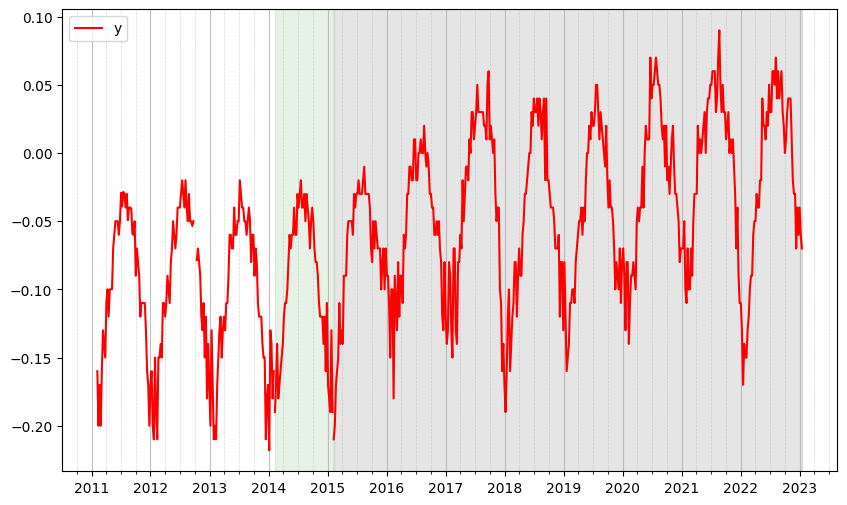

In [145]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_data(
    data_processor=data_processor,
    plot_column=output_col,
    # plot_test_data=False,
    sub_plot=ax,
    validation_label="y",
)
plt.legend()
plt.show()

In [146]:
# Components
sigma_v = 1e-1
local_trend = LocalTrend(var_states=[1e-2, 1e-2])
local_acceleration = LocalAcceleration()
lstm_network = LstmNetwork(
    look_back_len=12,
    num_features=2,
    num_layer=1,
    num_hidden_unit=50,
    device="cpu",
    # manual_seed=1,
)
noise = WhiteNoise(std_error=sigma_v)

In [147]:
# Normal model
model = Model(
    local_trend,
    lstm_network,
    noise,
)

#  Abnormal model
ab_model = Model(
    local_acceleration,
    lstm_network,
    noise,
)

# Switching Kalman filter
skf = SKF(
    norm_model=model,
    abnorm_model=ab_model,
    std_transition_error=1e-3,
    norm_to_abnorm_prob=1e-5,
    abnorm_to_norm_prob=1e-1,
    norm_model_prior_prob=0.99,
)
skf.auto_initialize_baseline_states(train_data["y"][0:51])

In [148]:
#  Training
num_epoch = 50
scheduled_sigma_v = 1
for epoch in tqdm(range(num_epoch), desc="Training Progress", unit="epoch"):
    # # Decaying observation's variance
    scheduled_sigma_v = exponential_scheduler(
        curr_v=scheduled_sigma_v, min_v=sigma_v, decaying_factor=0.9, curr_iter=epoch
    )
    noise_index = model.states_name.index("white noise")
    skf.model["norm_norm"].process_noise_matrix[noise_index, noise_index] = (
        scheduled_sigma_v**2
    )

    # Train the model
    (mu_validation_preds, std_validation_preds, train_states) = skf.lstm_train(
        train_data=train_data, validation_data=validation_data
    )

    # # Unstandardize the predictions
    mu_validation_preds = normalizer.unstandardize(
        mu_validation_preds,
        data_processor.norm_const_mean[output_col],
        data_processor.norm_const_std[output_col],
    )
    std_validation_preds = normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.norm_const_std[output_col],
    )

Training Progress: 100%|██████████| 50/50 [00:00<00:00, 52.90epoch/s]


In [149]:
mse = metric.mse(
    mu_validation_preds, data_processor.validation_data[:, output_col].flatten()
)
print(f"MSE           : {mse: 0.4f}")

MSE           :  0.0008


In [150]:
# # Anomaly Detection
skf.model["norm_norm"].process_noise_matrix[noise_index, noise_index] = sigma_v**2
filter_marginal_abnorm_prob, _ = skf.filter(data=all_data)
smooth_marginal_abnorm_prob, states = skf.smoother(data=all_data)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

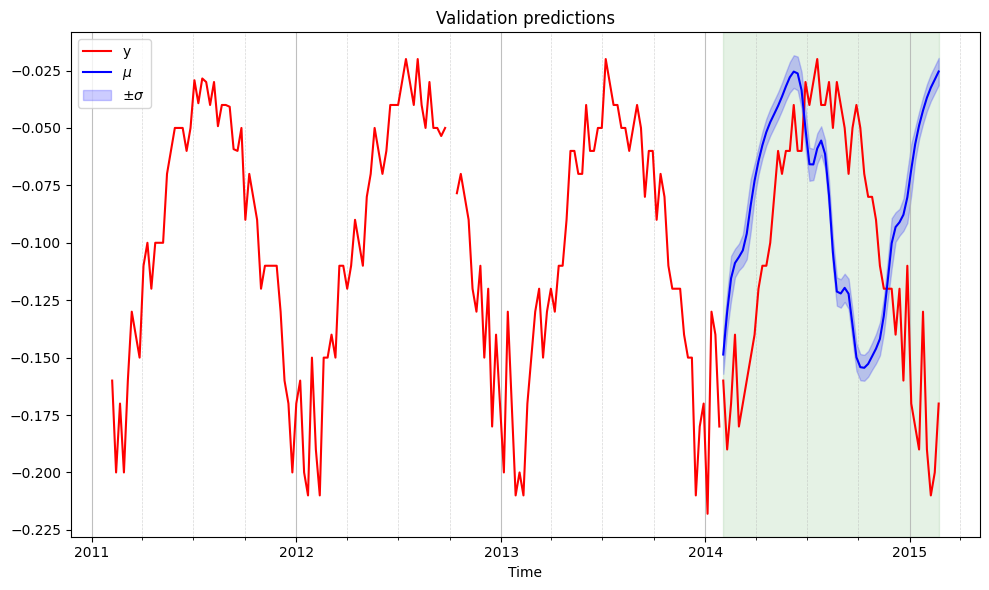

In [122]:
# # Plot
marginal_abnorm_prob_plot = filter_marginal_abnorm_prob
fig, ax = plt.subplots(figsize=(10, 6))
plot_data(
    data_processor=data_processor,
    plot_column=output_col,
    plot_test_data=False,
    sub_plot=ax,
    validation_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds,
    std_validation_pred=std_validation_preds,
    sub_plot=ax,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
ax.set_xlabel("Time")
plt.title("Validation predictions")
plt.tight_layout()
plt.legend()
plt.show()

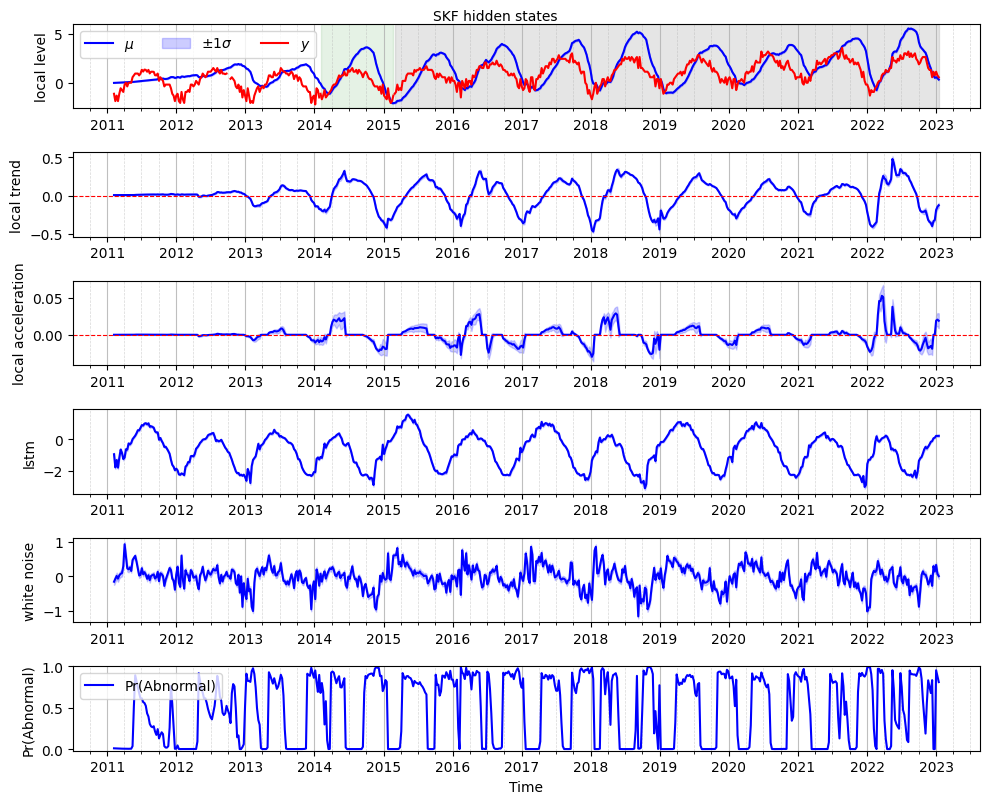

In [123]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=marginal_abnorm_prob_plot,
    color="b",
    legend_location="upper left",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)
plt.show()